Preparing to run the notebook: 

```
conda install -c conda-forge rubin-sim
curl -O https://minorplanetcenter.net/Extended_Files/mpcorb_extended.json.gz
gunzip mpcorb_extended.json.gz
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.time import Time
import rubin_sim.maf as maf

First deal with the MPC data (for discovered objects).

In [2]:
mpc = pd.read_json('mpcorb_extended.json')

In [3]:
mpc.columns

Index(['H', 'G', 'Num_obs', 'rms', 'U', 'Arc_years', 'Perturbers',
       'Perturbers_2', 'Number', 'Name', 'Principal_desig', 'Other_desigs',
       'Epoch', 'M', 'Peri', 'Node', 'i', 'e', 'n', 'a', 'Ref', 'Num_opps',
       'Computer', 'Hex_flags', 'Last_obs', 'Tp', 'Orbital_period',
       'Perihelion_dist', 'Aphelion_dist', 'Semilatus_rectum',
       'Synodic_period', 'Orbit_type', 'NEO_flag', 'One_km_NEO_flag',
       'PHA_flag', 'Critical_list_numbered_object_flag',
       'One_opposition_object_flag', 'Arc_length'],
      dtype='object')

In [4]:
def discovery_year_extended(x):
    if isinstance(x['Arc_years'], str):
        yr_discovered = x['Arc_years'].split('-')[0]
    elif '-' not in x['Principal_desig']:
        yr_discovered = x['Principal_desig'].split(' ')[0]
    else:
        yr_discovered = '0'
    yr_discovered = yr_discovered.replace('A', '1')
    yr_discovered = int(yr_discovered)
    return yr_discovered

In [5]:
yy = mpc.apply(discovery_year_extended, axis=1)

In [6]:
mpc['discovery_year'] = yy

In [7]:
mpc.head()

,H,G,Num_obs,rms,U,Arc_years,Perturbers,Perturbers_2,Number,Name,...,Semilatus_rectum,Synodic_period,Orbit_type,NEO_flag,One_km_NEO_flag,PHA_flag,Critical_list_numbered_object_flag,One_opposition_object_flag,Arc_length,discovery_year
0,3.34,0.15,7335.0,0.65,0,1801-2023,M-v,30k,(1),Ceres,...,1.375011,1.277520,MBA,NaN,NaN,NaN,NaN,NaN,NaN,1801
1,4.12,0.15,8889.0,0.59,0,1804-2023,M-c,28k,(2),Pallas,...,1.311648,1.276969,MBA,NaN,NaN,NaN,NaN,NaN,NaN,1804
2,5.17,0.15,7512.0,0.63,0,1804-2023,M-v,3Ek,(3),Juno,...,1.247019,1.297530,MBA,NaN,NaN,NaN,NaN,NaN,NaN,1804
3,3.25,0.15,7594.0,0.63,0,1821-2024,M-p,18k,(4),Vesta,...,1.171512,1.380238,MBA,NaN,NaN,NaN,NaN,NaN,NaN,1821
4,7.00,0.15,3250.0,0.71,0,1845-2024,M-v,3Ek,(5),Astraea,...,1.243176,1.318817,MBA,NaN,NaN,NaN,NaN,NaN,NaN,1845


In [8]:
mpc.Orbit_type.unique()

array(['MBA', 'Phocaea', 'Object with perihelion distance < 1.665 AU',
       'Hilda', 'Amor', 'Hungaria', 'Jupiter Trojan', 'Apollo',
       'Distant Object', 'Aten', 'Atira'], dtype=object)

Now let's load up predicted LSST discoveries, using metric results from MAF. We also define some metrics here that are similar to but different from the ones already in MAF (they just make this version a little easier, plus add MBA dn_dh. 

In [9]:
class TotalSSOAtTimeMetric(maf.BaseMoMetric):
    def __init__(self, times, h_mark, dndh_func, **kwargs):
        self.h_mark = h_mark
        self.times = times
        self.dndh_func = dndh_func
        metric_name = f'TotalN>={self.h_mark :.1f}'
        units = "N with H<= {self.h_mark :.1f}"
        super().__init__(metric_name=metric_name, units=units, **kwargs)

    def run(self, discovery_times, h_vals):
        if len(h_vals) != discovery_times.shape[1]:
            warnings.warn(
                "This summary metric expects cloned H distribution. Cannot calculate summary."
            )
            return
        n_ssos = discovery_times.shape[0]
        timesin_h = discovery_times.swapaxes(0, 1)
        diff_completeness_h = np.empty([len(h_vals), len(self.times)], float)
        for i, H in enumerate(h_vals):
            # figure out when what part of the population is found as a function of time
            # (this is cumulative over time)
            goodtimes = timesin_h[i].compressed()
            goodtimes = goodtimes[np.where(goodtimes > 0)]
            n, b = np.histogram(goodtimes, bins=self.times)
            diff_completeness_h[i][0] = 0
            diff_completeness_h[i][1:] = n.cumsum()
        diff_completeness_h = diff_completeness_h / float(n_ssos)
        # Swap order time - then h
        diff_completeness = diff_completeness_h.swapaxes(0, 1)
        # Calculate the total number down to hcutoff at each time
        n_obj = np.zeros(len(self.times))
        for i, t in enumerate(self.times):
            totals = maf.sum_over_h(diff_completeness[i,:], h_vals, self.dndh_func)
            n_obj[i] = np.interp(self.h_mark, h_vals, totals)
        # well .. some machinery means that we have to do this .. 
        summary_val = np.empty(
            len(self.times), dtype=[("name", np.str_, 20), ("value", float)]
        )
        summary_val["value"] = n_obj
        for i, time in enumerate(self.times):
            summary_val["name"][i] = "%s @ %.2f" % (self.units, time)
        return summary_val

In [10]:
def mba_dndh_skads(hvalues, **kwargs):
    binratio = (np.diff(hvalues, append=hvalues[-1] + np.diff(hvalues)[-1])) 
    y1 = np.zeros(len(hvalues))
    C = np.log10(50000) # @ H=14.5
    condition = np.where(hvalues>14.5)
    y1[condition] = np.power(10, C + 0.38 * (hvalues[condition] - 14.5) )
    condition = np.where(hvalues<=14.5)
    y1[condition] = np.power(10, C + 0.51 * (hvalues[condition] - 14.5))
    dndh = y1 * binratio
    return dndh

def mba_dndh_sdss(hvalues, **kwargs):
    binratio = (np.diff(hvalues, append=hvalues[-1] + np.diff(hvalues)[-1]))
    x = hvalues - 15.7
    y1 = (267000 * (np.power(10, 0.43*x))/(np.power(10, 0.18*x) + np.power(10, -0.18*x)))
    dndh = y1 * binratio
    return dndh

In [11]:
# Read in metric results (see files in this repo) 
file_name = 'baseline_v3_3_10yrs_DiscoveryTime_MBA_3_pairs_in_30_nights_detection_loss_MOOB.npz'
mba = maf.create_empty_mo_metric_bundle()
mba.read(file_name)

file_name = 'baseline_v3_3_10yrs_DiscoveryTime_NEO_3_pairs_in_30_nights_detection_loss_MOOB.npz'
neo = maf.create_empty_mo_metric_bundle()
neo.read(file_name)

In [12]:
# Set "start" to be the start of the survey .. this is, of course, approximate.

start = Time('2025-05-01', format='isot', scale='utc').mjd
times = np.arange(start, start + 10.5*365.25, 365.25)

nn = TotalSSOAtTimeMetric(times, 25.5, dndh_func=maf.neo_dndh_granvik)

neo_n = maf.make_completeness_bundle(
                    neo, nn, h_mark=None, results_db=None
                )
neo_n.metric_values

masked_array(data=[[0.0, 19411.59178228046, 30413.49991521493,
                    39395.1607129781, 48266.69141904053,
                    55097.412194515106, 62194.14263549759,
                    67882.76103377352, 71594.08317286403,
                    79171.18319518425, 84742.45432485966]],
             mask=[[False, False, False, False, False, False, False,
                    False, False, False, False]],
       fill_value=0.0)

In [13]:
mm = TotalSSOAtTimeMetric(times, 20.5, dndh_func=mba_dndh_sdss)

mba_n = maf.make_completeness_bundle(
                    mba, mm, h_mark=None, results_db=None
                )

In [14]:
# Now identify number of objects in each year. 
#  Take some fraction of previously discovered MBAs and NEOs out of the first few years values
# (note that after year 2, the number of new LSST discoveries is much lower .. I'd expect them also to be fainter
mba_per_year  = (mba_n.metric_values)[0][1:] - (mba_n.metric_values)[0][:-1] 
mba_per_year[0] = mba_per_year[0] - len(mpc.query('Orbit_type == "MBA"'))/2
mba_per_year[1] = mba_per_year[1] - len(mpc.query('Orbit_type == "MBA"'))/4
neo_per_year = (neo_n.metric_values)[0][1:] - (neo_n.metric_values)[0][:-1] 
neo_per_year[0] = neo_per_year[0] - len(mpc.query('NEO_flag == 1'))/5
neo_per_year[1] = neo_per_year[1] - len(mpc.query('NEO_flag == 1'))/5
neo_per_year[2] = neo_per_year[2] - len(mpc.query('NEO_flag == 1'))/5

Okay, now make the plot! 

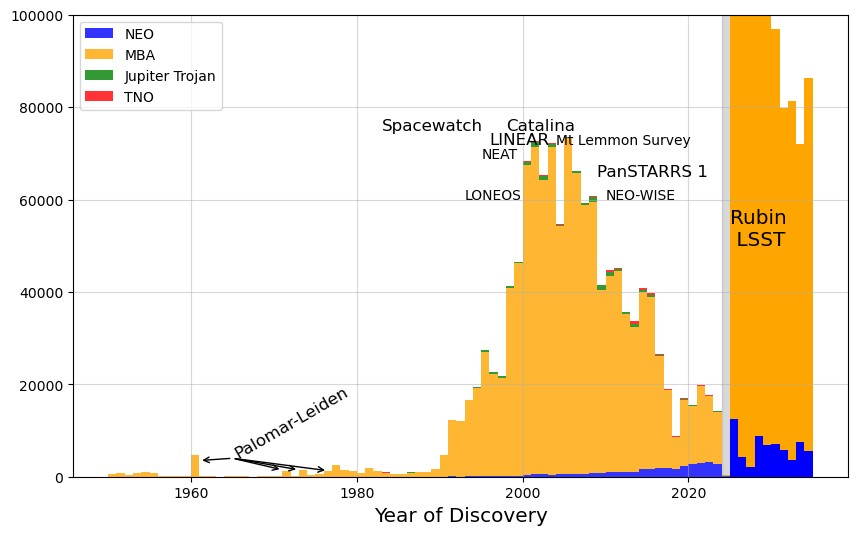

In [15]:
bins = np.arange(1950, 2035, 1)
plt.figure(figsize=(10, 6))
mpcneo = mpc.query('NEO_flag == 1').discovery_year.values
mpcmba = mpc.query('Orbit_type == "MBA"').discovery_year.values
jovian = mpc.query('Orbit_type == "Jupiter Trojan"').discovery_year.values
distant = mpc.query('Orbit_type == "Distant Object"').discovery_year.values
n,b,p = plt.hist([mpcneo, mpcmba, jovian, distant], bins, stacked=True,
                 alpha=0.8,
                 label=['NEO', 'MBA', 'Jupiter Trojan', 'TNO'],
                color=['blue', 'orange', 'green', 'red'])
#n,b,p = plt.hist(mpc.discovery_year.values, bins)
plt.grid(True, alpha=0.5)
plt.legend(loc='upper left', fancybox=True)
plt.ylim(0, 100000)
plt.annotate('Palomar-Leiden', xy=(1965, 4000), fontsize='large', rotation=30)
plt.annotate("", xy=(1961, 3500), xytext=(1965, 4000), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(1971, 1500), xytext=(1965, 4000), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(1973, 1500), xytext=(1965, 4000), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(1976.5, 1300), xytext=(1965, 4000), arrowprops=dict(arrowstyle="->"))
plt.annotate('Spacewatch', xy=(1983, 75000), fontsize='large')
plt.annotate('LINEAR', xy=(1996, 72000), fontsize='large')
plt.annotate('LONEOS', xy=(1993, 60000))
plt.annotate('NEAT', xy=(1995, 69000))
plt.annotate('Catalina', xy=(1998, 75000), fontsize='large')
plt.annotate('Mt Lemmon Survey', xy=(2004, 72000))
plt.annotate('PanSTARRS 1', xy=(2009, 65000), fontsize='large')
plt.annotate('NEO-WISE', xy=(2010, 60000))
# Fill gray space between "now" and "LSST start"
plt.fill_between([2024, 2025.5], 0, 1000000, color='gray', alpha=0.3)

years = np.arange(2025, 2035, 1)
plt.bar(years, neo_per_year, width=1, align='edge', color='blue')
plt.bar(years, mba_per_year, bottom=neo_per_year, width=1, align='edge', color='orange')
plt.annotate('Rubin\n LSST', xy=(2025, 50000), fontsize='x-large')

plt.xlabel("Year of Discovery", fontsize='x-large')
plt.savefig("discovery_years_zoom.png", format='png')

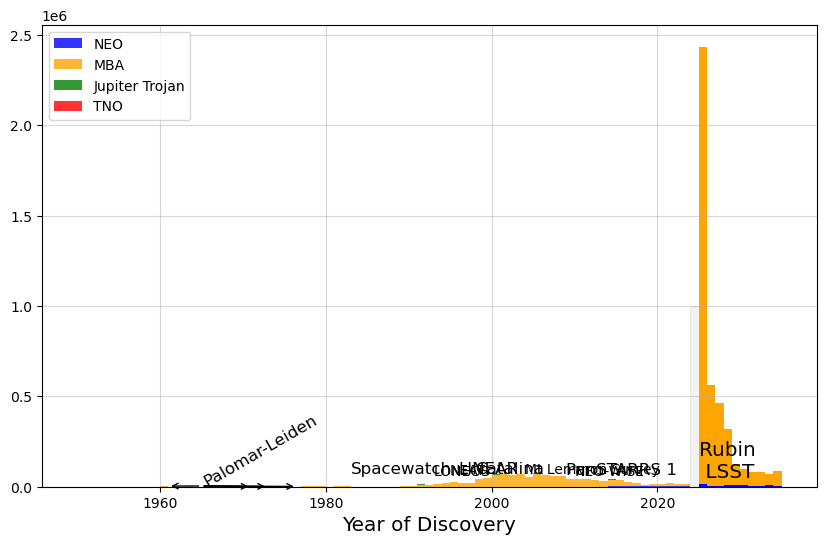

In [16]:
# Repeat, but different limits .. 

bins = np.arange(1950, 2035, 1)
plt.figure(figsize=(10, 6))
mpcneo = mpc.query('NEO_flag == 1').discovery_year.values
mpcmba = mpc.query('Orbit_type == "MBA"').discovery_year.values
jovian = mpc.query('Orbit_type == "Jupiter Trojan"').discovery_year.values
distant = mpc.query('Orbit_type == "Distant Object"').discovery_year.values
n,b,p = plt.hist([mpcneo, mpcmba, jovian, distant], bins, stacked=True,
                 alpha=0.8,
                 label=['NEO', 'MBA', 'Jupiter Trojan', 'TNO'],
                color=['blue', 'orange', 'green', 'red'])
#n,b,p = plt.hist(mpc.discovery_year.values, bins)
plt.grid(True, alpha=0.5)
plt.legend(loc='upper left', fancybox=True)
#plt.ylim(0, 100000)
plt.annotate('Palomar-Leiden', xy=(1965, 4000), fontsize='large', rotation=30)
plt.annotate("", xy=(1961, 3500), xytext=(1965, 4000), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(1971, 1500), xytext=(1965, 4000), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(1973, 1500), xytext=(1965, 4000), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(1976.5, 1300), xytext=(1965, 4000), arrowprops=dict(arrowstyle="->"))
plt.annotate('Spacewatch', xy=(1983, 75000), fontsize='large')
plt.annotate('LINEAR', xy=(1996, 72000), fontsize='large')
plt.annotate('LONEOS', xy=(1993, 60000))
plt.annotate('NEAT', xy=(1995, 69000))
plt.annotate('Catalina', xy=(1998, 75000), fontsize='large')
plt.annotate('Mt Lemmon Survey', xy=(2004, 72000))
plt.annotate('PanSTARRS 1', xy=(2009, 65000), fontsize='large')
plt.annotate('NEO-WISE', xy=(2010, 60000))
# gray bar 
plt.fill_between([2024, 2025.5], 0, 1000000, color='gray', alpha=0.1)

years = np.arange(2025, 2035, 1)
plt.bar(years, neo_per_year, width=1, align='edge', color='blue')
plt.bar(years, mba_per_year, bottom=neo_per_year, width=1, align='edge', color='orange')
plt.annotate('Rubin\n LSST', xy=(2025, 50000), fontsize='x-large')

plt.xlabel("Year of Discovery", fontsize='x-large')
plt.savefig("discovery_years_wide.png", format='png')

In [23]:
# It can be interesting to just see (cumulative) numbers of objects per year (down to a given H magnitude)
mm = TotalSSOAtTimeMetric(times, 23, dndh_func=mba_dndh_sdss)

mba_n = maf.make_completeness_bundle(
                    mba, mm, h_mark=None, results_db=None
                )
pd.DataFrame(mba_n.metric_values.compressed()/1e6, 
             index=np.concatenate([years, np.array([years[0]+10])]), 
             columns=['Millions of MBAs'])[1:]

,Millions of MBAs
2026,3.342164
2027,4.506758
2028,5.172815
2029,5.676509
2030,5.902938
2031,6.110523
2032,6.258557
2033,6.403962
2034,6.525758
2035,6.692622


In [27]:
# It can be interesting to just see (cumulative) numbers of objects per year (down to a given H magnitude)
nn = TotalSSOAtTimeMetric(times, 26, dndh_func=maf.neo_dndh_granvik)

neo_n = maf.make_completeness_bundle(
                    neo, nn, h_mark=None, results_db=None
                )

pd.DataFrame(neo_n.metric_values.compressed()/1e3, 
             index=np.concatenate([years, np.array([years[0]+10])]), 
             columns=['Thousands of NEOs'])[1:]

,Thousands of NEOs
2026,22.700845
2027,35.669014
2028,46.144798
2029,58.051287
2030,66.376131
2031,75.997629
2032,81.686247
2033,85.567099
2034,95.838496
2035,103.887822
